# 521153S, Deep Learning Final Project: Mini Image classification Competition with CNN

## Outline 
### In this assignment, you will learn:
* Combine all you learned from the previous assignments.
* Build your own CNN as you like with Pytorch, train and validate it on a given dataset.
* Test your CNN model on our server.

### Tasks (<span style="color:orange">40 points</span>)
We want to keep the task as clean and simple as possible. 
1. You would be given a dataset containing 45,000 grayscale 32x32 images. Also, we will set a private testing data and upload it to our server. You could only use the private testing data to test your model. Instructions about evaluating your model would be given along with the project in Moodle.
2. Before evaluating your model on the server, you have to train your model based on the given 45,000 images. Specifically, in these images, there are nine classes, and each class has 5000 images. The testing data on the server has 9000 images, and each class has 1000 images.
3. To get a good CNN model, basically, there are some rules for you to follow which would be considered when grading your report:
  * Make the best out of the given images. It means you have to split it into training and validation set, training your model on the training set and validating the trained model on the validation set. If the accuracy on the validation set is not good, then you have to adjust your CNN model structure or some adjustable parameters. For example, batch size, learning rate, momentum on SGD, lambda in weight decay, etc.  Then retrain your model until the accuracy on the validation set is good enough because the testing data would have similar accuracy with the validation set. 
  * It also means that you could do some augmentation on the training set. This includes randomly flipping, cropping a small window in a random location within the image(refer to assignment 4), adding some noise, resizing-and-cropping, etc. All these are to make the training process more tolerant. 
  * From the CNN structure perspective, you also need to design your CNN model by yourself. Well-known network architecture you can use includes [ResNet](https://arxiv.org/abs/1512.03385), [Inception](https://arxiv.org/abs/1512.00567), [VGGNet](https://arxiv.org/abs/1409.1556), [DenseNet](https://arxiv.org/abs/1608.06993), [MobileNet](https://arxiv.org/abs/1801.04381), [ShuffleNet](https://arxiv.org/abs/1807.11164), [ResNeXt](https://arxiv.org/abs/1611.05431) etc. 
4. Similar to real-life applications, your model will be tested with unknown data. In this project,  after training and validating the model, you need to test it on our hold-on testing dataset. We will provide you with a submission server and a leaderboard. The instructions would be given alongside the project in Moodle. 
5. Please give a pdf report (also your source code, e.g., this Jupyter notebook file), documenting the whole model training process and also the evaluated accuracy on the server. Tensorboard visualization is also necessary for your report to visualize your network structure, accuracy, and losses, etc. as done in assignment 4.
6. You need to return the pdf report as well as your trained model (a checkpoint file) with your source code file to moodle. We will run your model on the server and compare the results with the one written in the reports. 

### Grading
You can get 40 points in total.
  * You will get <span style="color:orange;font-weight:bold">20 points</span> if your model achieve more than 82.5% of the testing accuracy.
  * You will get <span style="color:orange;font-weight:bold">20 points</span> if your report is clear and well-organized.
  
### Files you have to submit
please submit a .zip file containing:
1. a pdf report;
2. source code files (jupyter notebook or common python files);
3. a checkpoint file (which saves your trained model).

### Group members
Maximum 2 members. 


### Environment
Python 3, Numpy, matplotlib, torch, torchvision...

### Dataset
Please follow the code below to download the 45,000 images and corresponding labels. <br>
We have already split them into training and validation set; please refer to assignment 3 and 4 to create your DataLoader, with your data augmentation methods. Good luck. 

#### Download the given dataset

In [1]:
# import necessary packages
import os, time
import torch 
import requests, zipfile, sys
import numpy as np
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader
from utils import download_given_data, get_preds_figure
import torchvision
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, utils
import random, matplotlib
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
from torchvision.models.resnet import BasicBlock

download_given_data('./')
print("GPU_available={}".format(torch.cuda.is_available()))

Data downloaded and extracted!
GPU_available=True


**Create a dataset class for our Mini ImageNet dataset**

In [2]:
class MiniImageNetDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        # Read the csv file
        self.frame = pd.read_csv(csv_file, header=None)
        self.transform = transform
        
        self.label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship']

    def __getitem__(self, idx):
        image_name = self.frame.iloc[idx, 0]
        image = Image.open(image_name)
        
        label = self.frame.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
            
        sample = {'image': image, 'label': label}

        return sample

    def __len__(self):
        return len(self.frame)

### Dataset checking ###

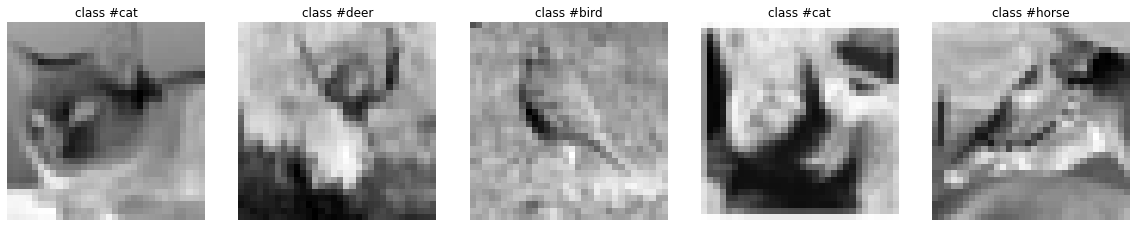

total number of training set: 36000
numer of images for class airplane: 4000
numer of images for class automobile: 4000
numer of images for class bird: 4000
numer of images for class cat: 4000
numer of images for class deer: 4000
numer of images for class dog: 4000
numer of images for class frog: 4000
numer of images for class horse: 4000
numer of images for class ship: 4000


In [3]:
train_set = MiniImageNetDataset(csv_file='./given_data/train.csv', transform=None)

num_to_show = 5
idx = np.random.choice(range(len(train_set)), num_to_show, replace=False)

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = train_set[idx[i]]['image'], train_set[idx[i]]['label']
    label_name = train_set.label_names[label]

    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(np.asarray(image), cmap=matplotlib.cm.binary)

plt.show()

# Print the number of total images in the training set
print('total number of training set: {}'.format(len(train_set)))

# Print the number of images per class in the training set
class_num_train = np.zeros(10, dtype=np.int32)
for x in train_set:
    class_num_train[x['label']] += 1
for i in range(9):
    print('numer of images for class {}: {}'.format(train_set.label_names[i], class_num_train[i]))

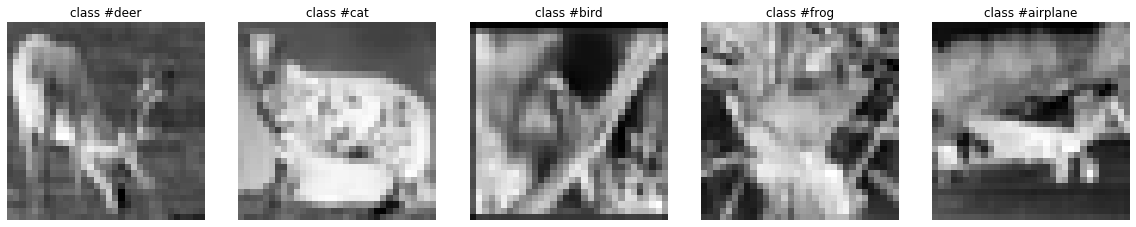

total number of validing set: 9000
numer of images for class airplane: 1000
numer of images for class automobile: 1000
numer of images for class bird: 1000
numer of images for class cat: 1000
numer of images for class deer: 1000
numer of images for class dog: 1000
numer of images for class frog: 1000
numer of images for class horse: 1000
numer of images for class ship: 1000


In [4]:
valid_set =  MiniImageNetDataset(csv_file='./given_data/val.csv', transform=None)

num_to_show = 5
idx = np.random.choice(range(len(valid_set)), num_to_show, replace=False)

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = valid_set[idx[i]]['image'], valid_set[idx[i]]['label']
    label_name = valid_set.label_names[label]    

    # TODO: show plots
    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(np.asarray(image), cmap=matplotlib.cm.binary)

plt.show()

# TODO: Print the number of total images in the validation set    
print('total number of validing set: {}'.format(len(valid_set)))

# TODO: Print the number of images per class in the validation set
class_num_val = np.zeros(10, dtype=np.int32)
for x in valid_set:
    class_num_val[x['label']] += 1
for i in range(9):
    print('numer of images for class {}: {}'.format(valid_set.label_names[i], class_num_val[i]))

### Build our custom data augmentation

We can define a custom data transformation for data augmentation namely RandomWindowDrop. There are 50%/50% chance that it will randomly cut a square window inside our image or horizontally flip the image.

In [5]:
class RandomWindowDrop(object):
    def __init__(self, window_size):
        assert isinstance(window_size, (int, tuple))
        if isinstance(window_size, int):
            self.window_size = (window_size, window_size)
        else:
            assert len(window_size) == 2
            self.window_size = window_size
        
        # Define a horizontalFlip
        self.trans = transforms.RandomHorizontalFlip(p=1.0)

    def __call__(self, sample):
        image = sample

        # Perform either RandomWindowDrop or RandomHorizontalFlip
        if random.random() < 0.5:
            h, w = image.size
            imagePixels = image.load()
            top = np.random.randint(self.window_size[0], h - self.window_size[0])
            left = np.random.randint(self.window_size[1], w - self.window_size[1])
            for i in range(top, top+self.window_size[0], 1):
                for j in range(left, left+self.window_size[1], 1):   
                    imagePixels[i, j] = 0
        else:
            image = self.trans(image)

        return image

**Load the training/validation data to Dataloader**

In [6]:
def getTrainingData(csv_file='./given_data/train.csv', batch_size=64, num_workers=0):
    __normalize_stats = {'mean': [0.5], 'std': [0.5]}

    # transforms.Compose create a list of transformations
    transformed_training = MiniImageNetDataset(csv_file=csv_file,
                                        transform=transforms.Compose([
                                            RandomWindowDrop(6),
                                            transforms.Resize(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize(__normalize_stats['mean'],
                                                      __normalize_stats['std'])
                                        ]))

    dataloader_training = DataLoader(transformed_training, batch_size, shuffle=True, num_workers=num_workers)

    return dataloader_training


def getEvalData(csv_file='./given_data/val.csv', batch_size=64, num_workers=0):
    __normalize_stats = {'mean': [0.5], 'std': [0.5]}

    transformed_eval = MiniImageNetDataset(csv_file=csv_file,
                                        transform=transforms.Compose([
                                            transforms.Resize(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize(__normalize_stats['mean'],
                                                      __normalize_stats['std'])
                                        ]))
    
    # DataLoader shuffle=False
    dataloader_eval = DataLoader(transformed_eval, batch_size, shuffle=True, num_workers=num_workers)

    return dataloader_eval

In [7]:
train_loader = getTrainingData(csv_file='./given_data/train.csv', batch_size=64, num_workers=0)

# batch_size = 64
valid_loader = getEvalData(csv_file='./given_data/val.csv', batch_size=64, num_workers=0)

###  Define the Network Architecture in Pytorch ###

In [8]:
## ------ ResNet18 -------- ##

class ResNet18_MiniImageNet(torchvision.models.ResNet):
    def __init__(self, num_classes=9):
        super(ResNet18_MiniImageNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
        # Override the "conv1" layer from the resnet-18 model
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
    def forward(self, x):
        return super(ResNet18_MiniImageNet, self).forward(x)

## Set ResNet18 Model

Ourmodel = 'ResNet18'
model = ResNet18_MiniImageNet(num_classes= 9).float()
    
## ------ ResNet50 -------- ##
# In order to keep memory on 8G GPU, please set 32 as batch size
## Set ResNet50 model
# Ourmodel = 'ResNet50'

# model = torchvision.models.resnet50(pretrained=False)
# model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# model.fc = torch.nn.Sequential(
#     torch.nn.Linear(
#         in_features=2048,
#         out_features=9
#     )
# #     torch.nn.Sigmoid()
# )

## ------ VGG 16 -------- ##


### Check the Model Architecture ###

ResNet18_MiniImageNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(i

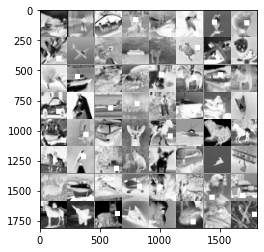

In [9]:
writer = SummaryWriter('tb_graphs/training')
val_writer = SummaryWriter('tb_graphs/validation')

    
# Print out the layers of our model
print(model)

# Get some random training images
_iter = iter(train_loader)
samples = _iter.next()
images = samples['image']

# Create grid of images
img_grid = torchvision.utils.make_grid(images)

# Show images
plt.imshow(img_grid.mean(dim=0).cpu().numpy(), cmap="Greys")

# Write to tensorboard
writer.add_image('train_images', img_grid)

# Write model graph to tensorboard
writer.add_graph(model, images)

### Set Parameteres ###

In [10]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#####Change model to cuda
if torch.cuda.is_available():
    model = model.cuda()


In [11]:
# evaluation function
def eval(net, data_loader):
    net.eval()
    correct = 0.0
    num_images = 0.0
    running_loss = 0.0
    loss_function = torch.nn.CrossEntropyLoss()
    for i, sample in enumerate(data_loader):
        #
        images, labels = sample['image'], sample['label']
        images, labels = images.to(device),labels.to(device)
        outs = net(images)
        _, preds = outs.max(1)
        correct += preds.eq(labels).sum()
        running_loss += loss_function(outs, labels).item()
        num_images += len(labels)

    acc = correct.float() / num_images
    loss = running_loss / len(data_loader)
    return acc, loss

# training function
def train(net, train_loader, valid_loader):
    # build SGD optimizer with learning rate=0.01, momentum=0.9, weight decay = 1e-4
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay= 1e-10)
    loss_function = torch.nn.CrossEntropyLoss()
    # Log training process to tensorboard every 100 iterations
    log_every = 100
    # Training for 20 epochs
    epoches = 50
    for epoch in range(epoches):
        if epoch > 30:
            optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9, weight_decay= 1e-10)
        start_t = time.time()
        net.train()
        running_loss = 0.0
        running_acc = 0.0
        for i, sample in enumerate(train_loader):
            images, labels = sample['image'], sample['label']
            images, labels = images.to(device),labels.to(device)
            # TODO: fill these blanks            
            outs = net(images)
            loss = loss_function(outs, labels)
            _, preds = outs.max(1)
            correct = preds.eq(labels).sum()
            running_acc += correct.float() / len(labels)
           
            # clear grads, back-propagation, backward propogation, update parameters
            # clear grads
            optimizer.zero_grad()
           
            # backward propogation
            loss.backward()

            # update parameters
            optimizer.step()
            net.eval()
                       
            running_loss += loss.item()
           
           
            if i % log_every == 99:
               
                print('[Epoch/iter]: [{}/{}], loss: {:.05f}, accuracy: {:.05f}'.format(epoch, i+1,
                           running_loss / log_every, running_acc / log_every))

                log_index = epoch * len(train_loader) + i
                # Log the training loss and accuracy
                # Example of using .add_scalar()
                # Note tag='Loss'
                writer.add_scalar('Loss', running_loss / log_every, log_index) # tag='Loss'
                # TODO: load the training accuracy using writer (0.5 points)
                # Note tag='Accuracy'
                writer.add_scalar('Accuracy', running_acc / log_every, log_index)
       
                # Log predictions
                # Example of using .add_figure()
                writer.add_figure('predictions', get_preds_figure(net, images, labels), log_index)
                running_loss = 0.0
                running_acc = 0.0

       
        # Running the validation

        acc_eval, loss_eval = eval(net, valid_loader)
        print('Elapsed time: {:.02f} seconds, end of epoch: {}, lr: {}, val_loss: {:.05f}, val_acc: {:.05f}'.format(
            time.time()-start_t, epoch, optimizer.param_groups[0]['lr'], loss_eval, acc_eval))
        # Log the validation loss and accuracy
        # Using val_writer will log the values to the validation writer
        val_log_index = epoch * len(valid_loader) + i
        # Note tag='Loss'
        val_writer.add_scalar('Loss', loss_eval, val_log_index) # tag='Loss'
        # TODO: load the validation accuracy using val_writer (0.5 points)
        # Note tag='Accuracy'
        val_writer.add_scalar('Accuracy', acc_eval, val_log_index)

    return net

In [12]:
train(model, train_loader, valid_loader)



[Epoch/iter]: [0/100], loss: 2.13800, accuracy: 0.18391
[Epoch/iter]: [0/200], loss: 2.02767, accuracy: 0.23891
[Epoch/iter]: [0/300], loss: 1.91348, accuracy: 0.28641
[Epoch/iter]: [0/400], loss: 1.82150, accuracy: 0.31750
[Epoch/iter]: [0/500], loss: 1.72956, accuracy: 0.34828
Elapsed time: 95.82 seconds, end of epoch: 0, lr: 0.01, val_loss: 1.64524, val_acc: 0.38178
[Epoch/iter]: [1/100], loss: 1.66139, accuracy: 0.38172
[Epoch/iter]: [1/200], loss: 1.57812, accuracy: 0.41094
[Epoch/iter]: [1/300], loss: 1.52633, accuracy: 0.42656
[Epoch/iter]: [1/400], loss: 1.49077, accuracy: 0.45453
[Epoch/iter]: [1/500], loss: 1.41741, accuracy: 0.47797
Elapsed time: 92.55 seconds, end of epoch: 1, lr: 0.01, val_loss: 1.34327, val_acc: 0.51244
[Epoch/iter]: [2/100], loss: 1.37973, accuracy: 0.49297
[Epoch/iter]: [2/200], loss: 1.31611, accuracy: 0.51703
[Epoch/iter]: [2/300], loss: 1.28327, accuracy: 0.53359
[Epoch/iter]: [2/400], loss: 1.21943, accuracy: 0.55359
[Epoch/iter]: [2/500], loss: 1.2

[Epoch/iter]: [22/100], loss: 0.15777, accuracy: 0.94844
[Epoch/iter]: [22/200], loss: 0.15534, accuracy: 0.94500
[Epoch/iter]: [22/300], loss: 0.16153, accuracy: 0.94734
[Epoch/iter]: [22/400], loss: 0.16051, accuracy: 0.94453
[Epoch/iter]: [22/500], loss: 0.15879, accuracy: 0.94703
Elapsed time: 92.87 seconds, end of epoch: 22, lr: 0.01, val_loss: 0.63169, val_acc: 0.82267
[Epoch/iter]: [23/100], loss: 0.13563, accuracy: 0.95359
[Epoch/iter]: [23/200], loss: 0.12816, accuracy: 0.95500
[Epoch/iter]: [23/300], loss: 0.12654, accuracy: 0.95625
[Epoch/iter]: [23/400], loss: 0.14637, accuracy: 0.94969
[Epoch/iter]: [23/500], loss: 0.16621, accuracy: 0.94062
Elapsed time: 92.51 seconds, end of epoch: 23, lr: 0.01, val_loss: 0.71750, val_acc: 0.81378
[Epoch/iter]: [24/100], loss: 0.11758, accuracy: 0.96047
[Epoch/iter]: [24/200], loss: 0.12630, accuracy: 0.95547
[Epoch/iter]: [24/300], loss: 0.11847, accuracy: 0.95969
[Epoch/iter]: [24/400], loss: 0.14255, accuracy: 0.95000
[Epoch/iter]: [2

Elapsed time: 94.62 seconds, end of epoch: 43, lr: 0.005, val_loss: 0.68340, val_acc: 0.84200
[Epoch/iter]: [44/100], loss: 0.03862, accuracy: 0.99078
[Epoch/iter]: [44/200], loss: 0.03082, accuracy: 0.99156
[Epoch/iter]: [44/300], loss: 0.03216, accuracy: 0.99219
[Epoch/iter]: [44/400], loss: 0.02621, accuracy: 0.99391
[Epoch/iter]: [44/500], loss: 0.03228, accuracy: 0.98937
Elapsed time: 95.18 seconds, end of epoch: 44, lr: 0.005, val_loss: 0.65258, val_acc: 0.84489
[Epoch/iter]: [45/100], loss: 0.03427, accuracy: 0.99281
[Epoch/iter]: [45/200], loss: 0.02581, accuracy: 0.99406
[Epoch/iter]: [45/300], loss: 0.02397, accuracy: 0.99453
[Epoch/iter]: [45/400], loss: 0.02705, accuracy: 0.99359
[Epoch/iter]: [45/500], loss: 0.02795, accuracy: 0.99297
Elapsed time: 94.18 seconds, end of epoch: 45, lr: 0.005, val_loss: 0.71156, val_acc: 0.83844
[Epoch/iter]: [46/100], loss: 0.04200, accuracy: 0.98859
[Epoch/iter]: [46/200], loss: 0.02876, accuracy: 0.99328
[Epoch/iter]: [46/300], loss: 0.03

ResNet18_MiniImageNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(i

In [12]:
model.load_state_dict(torch.load('./BestModelResNet18.pth'))

<All keys matched successfully>

In [13]:
### Just for check valid set result

acc_eval, loss_eval = eval(model, valid_loader)
print('val_loss: {:.05f}, val_acc: {:.05f}'.format(loss_eval, acc_eval))

val_loss: 0.66445, val_acc: 0.84289


In [47]:
# In this part, we hope we can save the weight for different models.
if Ourmodel == 'ResNet18':
    
    # Save the weight of current model to disk
    PATH = './ResNet18.pth'
    torch.save(model.state_dict(), PATH)
    # Load the model weights
    model.load_state_dict(torch.load('./ResNet18.pth'))

if Ourmodel == 'ResNet50':
    
    # Save the weight of current model to disk
    PATH = './ResNet50.pth'
    torch.save(model.state_dict(), PATH)
    # Load the model weights
    model.load_state_dict(torch.load('./ResNet50.pth'))

In [59]:
# Define best model name and record temporily
PATH = './BestModel***.pth'
torch.save(model.state_dict(), PATH)

**Record for Train and Valid Set Accuracy**
* ResNet50: 96% and 80% ---- 0.01 lr, 1e-4 weight decay and 32 batch size 
* ResNet18: 96% and 82% ---- 0.01 lr, 1e-4 weight decay and 128 batch size
* ResNet18: 92% and 78% ---- 0.005 lr, 1e-4 weight decay and 32 batch size
* ResNet18: 98% and 84.2% ---- 0.006 lr and lr decay, 1e-10 weight decay and 64 batch size

### Run test set on our model

In [14]:
def getTestData(csv_file='./group_002_test.csv', batch_size=64, num_workers=0):
    __normalize_stats = {'mean': [0.5], 'std': [0.5]}

    transformed_eval = MiniImageNetDataset(csv_file=csv_file,
                                        transform=transforms.Compose([
                                            transforms.Resize(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize(__normalize_stats['mean'],
                                                      __normalize_stats['std'])
                                        ]))
    
    # DataLoader shuffle=False
    dataloader_eval = DataLoader(transformed_eval, batch_size, shuffle=False, num_workers=num_workers)

    return dataloader_eval

In [15]:
test_loader = getTestData(csv_file='./group_002_test.csv', batch_size=64, num_workers=0)

**Import Model**

In [12]:
model.load_state_dict(torch.load('./BestModelResNet18.pth'))

<All keys matched successfully>

**Define function to write the file into 'test.txt' file**

In [16]:
def getPretest(net, data_loader):
    net.eval()
    # Create new file
    f= open("test28_12.txt","w+")
    for i, sample in enumerate(data_loader):
        #Define image for cuda
        images, labels = sample['image'], sample['label']
        batch_size = len(images)
        images, labels = images.to(device),labels.to(device)
        outs = net(images)
        _, preds = outs.max(1)
        # Write down txt
        for k in range(batch_size):
            f.write(str(preds[k].item()) + '\n')


In [18]:
getPretest(model, test_loader)